# Entanglement Boosting: Step-by-Step Complete Understanding Guide

This notebook walks through the entire repository step by step.

## Notebook Structure

1. **Setup and Imports** - Checking required libraries
2. **Stim Basics** - Fundamentals of quantum circuit simulation library
3. **Utility Layer Deep Dive** - QubitMapping, Circuit, NoiseConfiguration
4. **Surface Code Understanding** - How syndrome measurements work
5. **Entanglement Boosting Protocol** - Details of the main algorithm
6. **Simulation and Result Analysis** - How to interpret results
7. **Advanced Examples** - With noise and post-selection enabled

## 0. Setup and Imports


In [2]:
import sys
from pathlib import Path

import stim
import pymatching

# --- Make local imports work regardless of notebook cwd ---
# We want to import from `src/` (which contains `entanglement_boosting.py`, `util.py`, etc.).
# Depending on how Jupyter is launched, the current working directory may be the repo root
# or the `notebooks/` directory.
repo_root = Path.cwd()
if not (repo_root / 'src').exists():
    # If we're in `notebooks/`, go one level up.
    if (repo_root.parent / 'src').exists():
        repo_root = repo_root.parent

src_path = str(repo_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import entanglement_boosting as eb
import util
import surface_code

print('cwd:', Path.cwd())
print('src_path:', src_path)
print('stim', stim.__version__)
print('pymatching', pymatching.__version__)

cwd: /Users/seigokikura/code/entanglement-boosting/notebooks
src_path: /Users/seigokikura/code/entanglement-boosting/src
stim 1.15.0
pymatching 2.3.1


## 1. Repository Map and Key Classes

This walkthrough focuses on these files:

- `src/util.py`: qubit coordinate mapping, circuit wrapper, and noise configuration.
- `src/surface_code.py`: stabilizer measurement patterns and helper classes.
- `src/entanglement_boosting.py`: distillation circuit builder and simulation helpers.
- `notebooks/entanglement_boosting_walkthrough.ipynb`: this step-by-step notebook.

We'll go from Stim basics → mapping/circuit wrapper → surface code patch → entanglement boosting → analysis.


## 2. Stim Basics: Building a Tiny Circuit


In [3]:
c = stim.Circuit()
c.append('H', 0)
c.append('M', 0)
print(c)

H 0
M 0


## 3. Stim Basics: Sampling


In [4]:
sampler = c.compile_sampler()
samples = sampler.sample(shots=10)
samples

array([[False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True]])

## 4. Stim built-in visualization (diagram)


## 5. Utility Layer: Deep Dive into Circuit Wrapper


Mapping size: width=3, height=3
Total number of qubits: 5
First 5 qubits: [(0, (0, 0)), (1, (0, 2)), (2, (2, 0)), (3, (2, 2)), (4, (1, 1))]

Qubit ID at coordinate (0,0): 0
Qubit ID at coordinate (1,1): 4

=== Circuit Construction ===

Generated circuit:
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(0, 2) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(2, 2) 3
QUBIT_COORDS(1, 1) 4
RX 0
R 2
TICK
CX 0 4
TICK
M 2
TICK


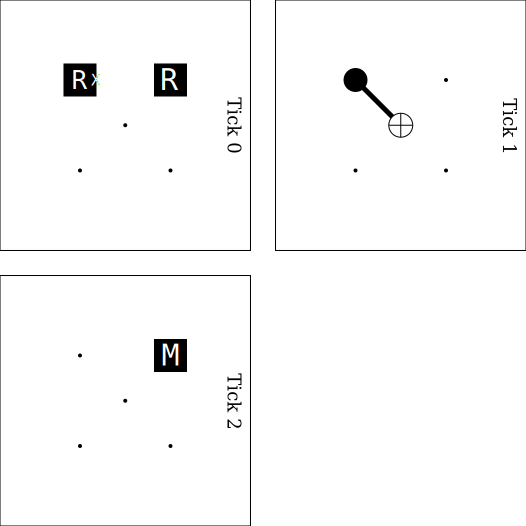

In [ ]:
# Create a small mapping and a noiseless circuit
mapping = util.QubitMapping(width=3, height=3)
print(f"Mapping size: width={mapping.width}, height={mapping.height}")
print(f"Total number of qubits: {len(mapping.mapping)}")
print(f"First 5 qubits: {mapping.mapping[:5]}")

# Example of getting ID from coordinates
print(f"\nQubit ID at coordinate (0,0): {mapping.get_id(0, 0)}")
print(f"Qubit ID at coordinate (1,1): {mapping.get_id(1, 1)}")

# Create circuit with noiseless configuration
noise = util.NO_ERROR_CONF
cwrap = util.Circuit(mapping, noise)

# Place a few operations using the wrapper
# IMPORTANT: `util.Circuit` enforces "one gate per tick per qubit".
# That means if a qubit is used by an operation, you must insert `place_tick()`
# before using that qubit again.
print("\n=== Circuit Construction ===")

# Tick 0: resets
cwrap.place_reset_x((0, 0))  # Reset in X basis
cwrap.place_reset_z((2, 0))  # Reset in Z basis
cwrap.place_tick()

# Tick 1: CX
cwrap.place_cx((0, 0), (1, 1))  # Controlled-NOT gate (nearest-neighbor only)
cwrap.place_tick()

# Tick 2: measurement
cwrap.place_measurement_z((2, 0))  # Measure in Z basis
cwrap.place_tick()  # Final tick

print("\nGenerated circuit:")
print(cwrap.circuit)

## 6. Surface Code Patch Layout


In [8]:
# Create a surface code patch
# Set distance/offset first so mapping is large enough for data + ancilla qubits.
distance = 3
offset = (1, 1)

# Data qubits live on even-even (or odd-odd) coordinates; ancillas are offset by +1.
max_data_x = offset[0] + (distance - 1) * 2
max_data_y = offset[1] + (distance - 1) * 2
max_ancilla_x = max_data_x + 1
max_ancilla_y = max_data_y + 1
mapping = util.QubitMapping(width=max_ancilla_x + 1, height=max_ancilla_y + 1)

cwrap = util.Circuit(mapping, util.NO_ERROR_CONF)

# SurfaceCodePatch parameters:
# - offset: Starting position of the patch
# - bell_distance: Distance of Bell pair (d_Bell)
# - distance: Surface code distance (d_s)
patch = eb.SurfaceCodePatch(cwrap, offset=offset, bell_distance=2, distance=distance)

print(f"Total number of syndrome measurements: {len(patch.syndrome_measurements)}")
print(f"\nFirst 5 syndrome measurement positions:")
for i, (pos, measurement) in enumerate(list(patch.syndrome_measurements.items())[:5]):
    print(f"  {i+1}. Position {pos}: {type(measurement).__name__}")

# Check logical X and Z Pauli strings
print(f"\nLogical X Pauli string: {patch.logical_x_pauli_string()}")
print(f"Logical Z Pauli string: {patch.logical_z_pauli_string()}")


Total number of syndrome measurements: 8

First 5 syndrome measurement positions:
  1. Position (2, 0): SurfaceXSyndromeMeasurement
  2. Position (2, 2): SurfaceZSyndromeMeasurement
  3. Position (4, 2): SurfaceXSyndromeMeasurement
  4. Position (6, 2): SurfaceZSyndromeMeasurement
  5. Position (0, 4): SurfaceZSyndromeMeasurement


ValueError: Qubit (1, 5) not found in mapping.

## 7. Building the Entanglement Boosting Circuit (Small Size)


In [ ]:
# Noiseless configuration (for easier understanding initially)
noise_conf = util.NoiseConfiguration(
    single_qubit_gate_error_probability=0.0,
    two_qubit_gate_error_probability=0.0,
    reset_error_probability=0.0,
    measurement_error_probability=0.0,
    idle_error_probability=0.0,
)

print("=== Building Entanglement Boosting Circuit ===")
print(f"bell_distance (d_Bell) = 2")
print(f"surface_distance (d_s) = 3")
print(f"Bell error probability = 0.0")
print(f"Post-selection = False\n")

circuits = eb.perform_distillation(
    bell_distance=2,
    surface_distance=3,
    noise_conf=noise_conf,
    bell_error_probability=0.0,
    post_selection=False,
)

print("Generated circuit (first 500 lines):")
circuit_str = str(circuits.circuit.circuit)
lines = circuit_str.split('\n')
for line in lines[:500]:
    print(line)
if len(lines) > 500:
    print(f"\n... (remaining {len(lines) - 500} lines)")

print(f"\nCircuit statistics:")
print(f"  Number of qubits: {circuits.circuit.circuit.num_qubits}")
print(f"  Number of measurements: {circuits.circuit.circuit.num_measurements}")
print(f"  Number of detectors: {circuits.circuit.circuit.num_detectors}")
print(f"  Number of observables: {circuits.circuit.circuit.num_observables}")

## 8. Simulating a Few Shots


In [ ]:
# Run simulation with a small number of shots
num_shots = 20
results = eb.perform_simulation(circuits, num_shots=num_shots, seed=0)

print(f"=== Simulation Results ===")
print(f"Total shots: {num_shots}")
print(f"Discarded samples: {results.num_discarded_samples}")
print(f"Valid samples: {len(results) - results.num_discarded_samples}")
print(f"Maximum gap: {results.max_gap()}")

# Check contents of each bucket
print(f"\n=== Gap Bucket Contents ===")
for gap, bucket in enumerate(results.buckets):
    if len(bucket) > 0:
        print(f"Gap [{gap}, {gap+1}): valid={bucket.num_valid_samples}, wrong={bucket.num_wrong_samples}, total={len(bucket)}")

## 8.1 Detailed Inspection of Complementary Gap Buckets


In [ ]:
# Show non-empty buckets
non_empty = [(i, b) for i, b in enumerate(results.buckets) if len(b) > 0]
print(f"Number of non-empty buckets: {len(non_empty)}")
print("\nFirst 5 buckets:")
for gap, bucket in non_empty[:5]:
    success_rate = bucket.num_valid_samples / len(bucket) if len(bucket) > 0 else 0
    print(f"  Gap [{gap}, {gap+1}): "
          f"valid={bucket.num_valid_samples}, "
          f"wrong={bucket.num_wrong_samples}, "
          f"success_rate={success_rate:.2%}")

## 9. Add Noise and See What Changes

Now we add realistic noise to see how error rates change and how post-selection helps.


In [ ]:
# Build circuit with noise configuration
noise_conf_with_errors = util.NoiseConfiguration(
    single_qubit_gate_error_probability=0.001,  # Single-qubit gate error probability
    two_qubit_gate_error_probability=0.001,     # Two-qubit gate error probability
    reset_error_probability=0.001,              # Reset error probability
    measurement_error_probability=0.001,        # Measurement error probability
    idle_error_probability=0.0001,              # Idle error probability
)

print("=== Building Circuit with Noise ===")
circuits_noisy = eb.perform_distillation(
    bell_distance=2,
    surface_distance=3,
    noise_conf=noise_conf_with_errors,
    bell_error_probability=0.01,  # Bell pair error probability (typically higher)
    post_selection=False,
)

# Simulate with more shots
print("\n=== Simulation with Noise ===")
results_noisy = eb.perform_simulation(circuits_noisy, num_shots=1000, seed=42)

print(f"Total shots: 1000")
print(f"Discarded samples: {results_noisy.num_discarded_samples}")
print(f"Valid samples: {len(results_noisy) - results_noisy.num_discarded_samples}")

# Calculate error rate
total_valid = sum(b.num_valid_samples for b in results_noisy.buckets)
total_wrong = sum(b.num_wrong_samples for b in results_noisy.buckets)
if total_valid + total_wrong > 0:
    error_rate = total_wrong / (total_valid + total_wrong)
    print(f"Error rate: {error_rate:.4f} ({error_rate*100:.2f}%)")

## 10. Simulation with Post-Selection


In [ ]:
# Build circuit with post-selection enabled
print("=== Building Circuit with Post-Selection ===")
circuits_postselect = eb.perform_distillation(
    bell_distance=2,
    surface_distance=3,
    noise_conf=noise_conf_with_errors,
    bell_error_probability=0.01,
    post_selection=True,  # Enable post-selection
)

# Run simulation
print("\n=== Simulation with Post-Selection ===")
results_postselect = eb.perform_simulation(circuits_postselect, num_shots=1000, seed=42)

print(f"Total shots: 1000")
print(f"Discarded samples: {results_postselect.num_discarded_samples}")
print(f"Valid samples: {len(results_postselect) - results_postselect.num_discarded_samples}")

# Calculate error rate
total_valid_ps = sum(b.num_valid_samples for b in results_postselect.buckets)
total_wrong_ps = sum(b.num_wrong_samples for b in results_postselect.buckets)
if total_valid_ps + total_wrong_ps > 0:
    error_rate_ps = total_wrong_ps / (total_valid_ps + total_wrong_ps)
    print(f"Error rate: {error_rate_ps:.4f} ({error_rate_ps*100:.2f}%)")
    print(f"\nComparison with error rate without post-selection:")
    if total_valid + total_wrong > 0:
        error_rate_no_ps = total_wrong / (total_valid + total_wrong)
        print(f"  Without post-selection: {error_rate_no_ps:.4f} ({error_rate_no_ps*100:.2f}%)")
        print(f"  With post-selection: {error_rate_ps:.4f} ({error_rate_ps*100:.2f}%)")
        improvement = (error_rate_no_ps - error_rate_ps) / error_rate_no_ps * 100 if error_rate_no_ps > 0 else 0
        print(f"  Improvement: {improvement:.1f}%")

## 11. Post-Selection Based on Complementary Gap


In [ ]:
# Calculate error rates at different discard rates
def analyze_discard_rates(results, num_shots):
    """Analyze error rates at different discard rates"""
    discard_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    num_unconditionally_discarded = results.num_discarded_samples
    num_total_samples = len(results)
    
    print(f"\n=== Analysis by Discard Rate ===")
    print(f"{'Discard Rate':<12} {'Gap Threshold':<15} {'Valid':<8} {'Wrong':<8} {'Discarded':<10} {'Error Rate':<12}")
    print("-" * 75)
    
    for discard_rate in discard_rates:
        num_valid = 0
        num_wrong = 0
        num_discarded = num_unconditionally_discarded
        discarding = True
        gap_threshold = results.max_gap()
        
        for (gap, bucket) in enumerate(results.buckets):
            if discarding and len(bucket) + num_discarded <= num_total_samples * discard_rate:
                num_discarded += len(bucket)
                continue
            
            if discarding:
                discarding = False
                gap_threshold = gap
            
            num_valid += bucket.num_valid_samples
            num_wrong += bucket.num_wrong_samples
        
        error_rate = num_wrong / (num_valid + num_wrong) if (num_valid + num_wrong) > 0 else float('nan')
        print(f"{discard_rate:<12.2f} {gap_threshold:<15} {num_valid:<8} {num_wrong:<8} {num_discarded:<10} {error_rate:<12.4f}")

# Analyze results with noise
analyze_discard_rates(results_noisy, 1000)

## 12. Parallel Simulation for Large-Scale Runs


In [ ]:
# Example of parallel simulation (using fewer shots for demonstration)
print("=== Parallel Simulation Example ===")
print("Note: For demonstration, we use a small number of shots.")
print("In practice, use larger num_shots (e.g., 10000+) to see benefits of parallelism.\n")

# Use the same circuit configuration as before
parallel_results = eb.perform_parallel_simulation(
    circuits_noisy,
    num_shots=2000,
    parallelism=2,  # Number of parallel processes
    num_shots_per_task=1000,  # Shots per task
    show_progress=True
)

print(f"\n=== Parallel Simulation Results ===")
print(f"Total shots: 2000")
print(f"Discarded samples: {parallel_results.num_discarded_samples}")
print(f"Valid samples: {len(parallel_results) - parallel_results.num_discarded_samples}")

# Calculate error rate
total_valid_par = sum(b.num_valid_samples for b in parallel_results.buckets)
total_wrong_par = sum(b.num_wrong_samples for b in parallel_results.buckets)
if total_valid_par + total_wrong_par > 0:
    error_rate_par = total_wrong_par / (total_valid_par + total_wrong_par)
    print(f"Error rate: {error_rate_par:.4f} ({error_rate_par*100:.2f}%)")

## 13. Larger Distance Simulation


In [ ]:
# Build circuit with larger distances
print("=== Building Circuit with Larger Distances ===")
print("bell_distance (d_Bell) = 3")
print("surface_distance (d_s) = 5")
print("This will take longer to build and simulate...\n")

circuits_large = eb.perform_distillation(
    bell_distance=3,
    surface_distance=5,
    noise_conf=noise_conf_with_errors,
    bell_error_probability=0.01,
    post_selection=False,
)

print(f"Circuit statistics:")
print(f"  Number of qubits: {circuits_large.circuit.circuit.num_qubits}")
print(f"  Number of measurements: {circuits_large.circuit.circuit.num_measurements}")
print(f"  Number of detectors: {circuits_large.circuit.circuit.num_detectors}")
print(f"  Number of observables: {circuits_large.circuit.circuit.num_observables}")

# Run a smaller number of shots for demonstration (larger distances are computationally expensive)
print("\n=== Simulation with Larger Distances ===")
print("Running 100 shots (larger distances require more computation)...")
results_large = eb.perform_simulation(circuits_large, num_shots=100, seed=123)

print(f"Total shots: 100")
print(f"Discarded samples: {results_large.num_discarded_samples}")
print(f"Valid samples: {len(results_large) - results_large.num_discarded_samples}")

# Calculate error rate
total_valid_large = sum(b.num_valid_samples for b in results_large.buckets)
total_wrong_large = sum(b.num_wrong_samples for b in results_large.buckets)
if total_valid_large + total_wrong_large > 0:
    error_rate_large = total_wrong_large / (total_valid_large + total_wrong_large)
    print(f"Error rate: {error_rate_large:.4f} ({error_rate_large*100:.2f}%)")
    print(f"\nComparison with smaller distance (d_s=3):")
    if total_valid + total_wrong > 0:
        error_rate_small = total_wrong / (total_valid + total_wrong)
        print(f"  Small distance (d_s=3): {error_rate_small:.4f} ({error_rate_small*100:.2f}%)")
        print(f"  Large distance (d_s=5): {error_rate_large:.4f} ({error_rate_large*100:.2f}%)")
        if error_rate_large < error_rate_small:
            improvement = (error_rate_small - error_rate_large) / error_rate_small * 100
            print(f"  Improvement: {improvement:.1f}%")

## 14. Understanding the Command-Line Interface


In [ ]:
# Display help information for the command-line interface
import subprocess
import sys

print("=== Command-Line Interface Usage ===")
print("\nTo run simulations from the command line, use:")
print("  python src/entanglement_boosting.py [options]\n")
print("Key options:")
print("  --num-shots: Number of simulation runs (default: 1000)")
print("  --error-probability: Error probability for gates (default: 0)")
print("  --bell-error-probability: Error probability for Bell pairs (default: 0)")
print("  --bell-distance: Distance of Bell pair in surface code")
print("  --surface-distance: Distance parameter for surface code patch (default: 3)")
print("  --post-selection: Enable early post-selection")
print("  --parallelism: Number of parallel processes (default: 1)")
print("  --show-progress: Show progress bar during simulation")
print("  --dump-results-to: Path to save simulation results (pickle format)\n")

print("Example command:")
print("  python src/entanglement_boosting.py \\")
print("    --num-shots 10000 \\")
print("    --error-probability 0.001 \\")
print("    --bell-error-probability 0.01 \\")
print("    --surface-distance 5 \\")
print("    --bell-distance 3 \\")
print("    --parallelism 4 \\")
print("    --show-progress")

## 15. Visualizing Results


In [ ]:
# Try to import matplotlib for visualization
try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Prepare data for plotting
    discard_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    error_rates = []
    valid_counts = []
    discarded_counts = []
    
    num_unconditionally_discarded = results_noisy.num_discarded_samples
    num_total_samples = len(results_noisy)
    
    for discard_rate in discard_rates:
        num_valid = 0
        num_wrong = 0
        num_discarded = num_unconditionally_discarded
        discarding = True
        
        for (gap, bucket) in enumerate(results_noisy.buckets):
            if discarding and len(bucket) + num_discarded <= num_total_samples * discard_rate:
                num_discarded += len(bucket)
                continue
            
            if discarding:
                discarding = False
            
            num_valid += bucket.num_valid_samples
            num_wrong += bucket.num_wrong_samples
        
        error_rate = num_wrong / (num_valid + num_wrong) if (num_valid + num_wrong) > 0 else float('nan')
        error_rates.append(error_rate)
        valid_counts.append(num_valid)
        discarded_counts.append(num_discarded)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Error rate vs discard rate
    ax1.plot(discard_rates, error_rates, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Discard Rate', fontsize=12)
    ax1.set_ylabel('Error Rate', fontsize=12)
    ax1.set_title('Error Rate vs Discard Rate', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-0.05, 0.55)
    
    # Plot 2: Valid samples vs discard rate
    ax2.plot(discard_rates, valid_counts, 's-', color='green', linewidth=2, markersize=8, label='Valid')
    ax2.plot(discard_rates, discarded_counts, '^-', color='red', linewidth=2, markersize=8, label='Discarded')
    ax2.set_xlabel('Discard Rate', fontsize=12)
    ax2.set_ylabel('Number of Samples', fontsize=12)
    ax2.set_title('Sample Distribution vs Discard Rate', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-0.05, 0.55)
    
    plt.tight_layout()
    plt.show()
    
    print("Visualization created successfully!")
    
except ImportError:
    print("Matplotlib not available. Skipping visualization.")
    print("To install: pip install matplotlib")
    print("\nSummary of discard rate analysis:")
    analyze_discard_rates(results_noisy, 1000)

## 16. Summary and Key Takeaways


### Key Concepts

1. **Stim Library**: High-performance quantum circuit simulation library used for building and simulating quantum circuits.

2. **Circuit Wrapper (`util.Circuit`)**: 
   - Enforces nearest-neighbor connectivity for two-qubit gates
   - Manages one gate per tick per qubit
   - Automatically injects noise based on gate types

3. **Surface Code Patches**:
   - Two patches are used in the entanglement boosting protocol
   - Each patch performs syndrome measurements to detect errors
   - Logical measurements are performed at the end

4. **Entanglement Boosting Protocol**:
   - Starts with noisy physical Bell pairs
   - Uses small code (d_Bell) for initial error detection
   - Escalates to larger code (d_s) for better error correction
   - Performs soft-output decoding and post-selection

5. **Complementary Gap**:
   - Important metric for assessing result reliability
   - Larger gaps indicate more reliable results
   - Used for post-selection to improve overall fidelity

6. **Post-Selection**:
   - Early error detection allows discarding low-quality results
   - Improves reliability of remaining results
   - Can be based on complementary gap thresholds

### Performance Considerations

- **Small distances** (d_s=3, d_Bell=2): Fast simulation, good for understanding
- **Larger distances** (d_s=5+): Better error correction but computationally expensive
- **Parallel simulation**: Use `perform_parallel_simulation` for large-scale runs
- **Post-selection**: Improves error rates but reduces the number of valid samples

## 17. Next Steps and Further Exploration
